In [53]:
# Import Modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import re

In [54]:
# Data Paths
data_dir = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/"
plot_dir = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun18" 
# Ensure both directories exist
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
raw_data_path = os.path.join(data_dir, "RadiationAndANN_DATA_2021-11-15_0835.csv")
out_data_path = os.path.join(data_dir, "RadiationAndANN_DATA_2021-11-15_0835_data_exploration.csv")
dictionary_path = os.path.join(data_dir, "RadiationAndANN_DataDictionary_2021-11-15.csv")

In [55]:
# Columns to be cross-tabulated
cross_tab_cols_set1 = ["PRE_susp_LN_prsnt_composite", "PRE_susp_LN_max_size_composite", "PRE_tumor_max_size_composite"]
# cross_tab_cols_set1 = ["PRE_height_cm", "PRE_weight_kg"]
cross_tab_cols_set2 = ['lymphovascular_invasion', 'metastasis', 'ln_w_micrometastasis', 'ln_w_macrometastasis', 'size_of_largest_nodal_meta', 'extranodal_extension', 'extent_of_extranodal_exten', 'did_the_patient_receive_pm']

# Global Variables 
susp_LN_present_composite_cols = [
        'abnormal_lymph',  # Ultrasound
        'prominent_axillary_lymph',  # Mammography
        'axillary_lymphadenopathy',  # MRI
        'internal_mammary_lymphaden',  # MRI
        'axillary_lymphadenopathy_p',
        'int_mammary_lymphade_pet',
        'axillary_lymph_node_palpab'
        ]
susp_LN_present_composite_cols = ["PRE_" + col for col in susp_LN_present_composite_cols]

susp_LN_max_size_composite_cols = [
    'lymph_node_max_size_mm',
    'lymph_node_max_size_mm0',
    'axillary_lymph_node_max_si',
    'internal_mammary_lymph_nod'
    ]
susp_LN_max_size_composite_cols = ["PRE_" + col for col in susp_LN_max_size_composite_cols]

pre_tumor_max_size_composite_cols = [
        "img_size",  # Ultrasound, in MM
        "tumor_size_mm",  # Mammography, in MM
        "size_of_the_largest_foci_c",  # PET, in CM
]
pre_tumor_max_size_composite_cols = ["PRE_" + col for col in pre_tumor_max_size_composite_cols]

pre_composite_col_names = [
        "PRE_susp_LN_prsnt_composite",
        "PRE_susp_LN_max_size_composite",
        "PRE_tumor_max_size_composite"
]
pre_sections = ['Demographics', 'Ultrasound report', 'Diagnostic mammogram report', 'MRI report', 'PET scan', 'Pre-operative Biopsy Report', 'Pre-Composite']
pos_sections = ['Intra-operative Findings', 'Post-operative Surgical Pathology Report']
pre_sections_abbr = [x[:3].upper() for x in pre_sections]
pos_sections_abbr = [x[:3].upper() for x in pos_sections]

In [56]:
susp_LN_present_composite_cols

['PRE_abnormal_lymph',
 'PRE_prominent_axillary_lymph',
 'PRE_axillary_lymphadenopathy',
 'PRE_internal_mammary_lymphaden',
 'PRE_axillary_lymphadenopathy_p',
 'PRE_int_mammary_lymphade_pet',
 'PRE_axillary_lymph_node_palpab']

In [57]:
# Load Data
df = pd.read_csv(raw_data_path)
# Convert the unit of "size_of_the_largest_foci_c" column from CM into MM, if it is not already in MM
df["size_of_the_largest_foci_c"] = df["size_of_the_largest_foci_c"] * 10
# Fill the Nan values with -1
df.fillna(-1, inplace=True)
df.head()

,record_id,dob,men_status,fmhx,gensus___1,gensus___2,gensus___3,gensus___4,gensus___5,gensus___6,...,dis_closest_margin,metastasis,ln_w_micrometastasis,ln_w_macrometastasis,size_of_largest_nodal_meta,extranodal_extension,extent_of_extranodal_exten,did_the_patient_receive_pm,did_the_patient_reject_pmr,data_collection_fields_complete
0,ANN001,10/1/60,2.0,0.0,0,0,0,0,0,1,...,-1,-1.0,-1.0,-1.0,-1,-1.0,-1,0.0,-1.0,2
1,ANN002,1/1/66,2.0,0.0,0,0,0,0,0,1,...,> 10,2.0,-1.0,-1.0,-1,2.0,-1,0.0,-1.0,2
2,ANN003,6/1/62,2.0,0.0,0,0,0,0,0,1,...,1,2.0,-1.0,-1.0,-1,2.0,-1,0.0,-1.0,2
3,ANN004,11/1/60,2.0,1.0,1,0,0,0,0,0,...,3,2.0,-1.0,-1.0,-1,2.0,-1,0.0,-1.0,2
4,ANN005,10/1/59,2.0,0.0,0,0,0,0,0,1,...,-1,1.0,0.0,1.0,5,1.0,-1,1.0,-1.0,2


In [58]:


# Load Data Dictionary
dictionary = pd.read_csv(dictionary_path)
# Rename "Variable / Field Name" to "Variable" column
dictionary.rename(columns={'Variable / Field Name': 'Variable'}, inplace=True)
# Rename "Choices, Calculations, OR Slider Labels" to "Options"
dictionary.rename(columns={'Choices, Calculations, OR Slider Labels': 'Options'}, inplace=True)
# Rename "Field Type" to "Type" 
dictionary.rename(columns={'Field Type': 'Type'}, inplace=True)
# Rename "Field Label" to "Label"
dictionary.rename(columns={'Field Label': 'Label'}, inplace=True)
# For the column "Section Header", replace NaN with the previous non-NaN value
dictionary["Section Header"].fillna(method='ffill', inplace=True)
# Rename "Section Header" to "Section"
dictionary.rename(columns={'Section Header': 'Section'}, inplace=True)
# Add the composite columns to dictionary
susp_LN_present_composite_row = {
    "Variable": "PRE_susp_LN_prsnt_composite",
    "Options": "0, absent | 1, present",
    "Type": "yesno",
    "Label": "Abnormal LN or lymphadenopathy, PRE",
    "Section": "Pre-Composite"
}
susp_LN_max_size_composite_row = {
    "Variable": "PRE_susp_LN_max_size_composite",
    "Type": "text",
    "Label": "Largest LN size, PRE",
    "Section": "Pre-Composite"
}
pre_tumor_max_size_composite_row = {
    "Variable": "PRE_tumor_max_size_composite",
    "Type": "text",
    "Label": "Largest tumor size, PRE",
    "Section": "Pre-Composite"
}
# Ensure all numeric columns are numeric
# Ensure all values are numeric, if not, replace with NaN
for i, row in dictionary.iterrows():
    col_name = row["Variable"]
    if (col_name in cross_tab_cols_set1 or col_name in cross_tab_cols_set2) and row["Type"] == "text":
        new_data = [float(x) if isinstance(x, (int, float)) or (x.replace(".","",1).isnumeric()) else np.nan for x in df[col_name]]
        # For each nan, print the original value
        skipped_data = [df.iloc[i][col_name] for i, x in enumerate(new_data) if np.isnan(x)]
        if len(skipped_data):
            print(f"{col_name} has {len(skipped_data)} invalid values: {skipped_data}")
        df[col_name] = new_data
# Fill all NaN values with -1
df.fillna(-1, inplace=True)
susp_LN_present_composite_row = pd.DataFrame(susp_LN_present_composite_row, index=[len(dictionary)])
susp_LN_max_size_composite_row = pd.DataFrame(susp_LN_max_size_composite_row, index=[len(dictionary)+ 1])
pre_tumor_max_size_composite_row = pd.DataFrame(pre_tumor_max_size_composite_row, index=[len(dictionary) + 2])
dictionary = pd.concat([dictionary, susp_LN_present_composite_row, susp_LN_max_size_composite_row, pre_tumor_max_size_composite_row])
cross_tab_cols_set2 = ["POS_" + col for col in cross_tab_cols_set2]
cross_tab_cols_set2.append('PRE_metastatic_carcinoma_on_ax')

dictionary

size_of_largest_nodal_meta has 1 invalid values: ['3o']
extent_of_extranodal_exten has 1 invalid values: ['?']


,Variable,Form Name,Section,Type,Label,Options,Field Note,Text Validation Type OR Show Slider Number,Text Validation Min,Text Validation Max,Identifier?,Branching Logic (Show field only if...),Required Field?,Custom Alignment,Question Number (surveys only),Matrix Group Name,Matrix Ranking?,Field Annotation
0,record_id,data_collection_fields,NaN,text,Record ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dob,data_collection_fields,Demographics,text,Date of Birth,NaN,NaN,date_ymd,NaN,NaN,NaN,NaN,y,NaN,NaN,NaN,NaN,NaN
2,men_status,data_collection_fields,Demographics,radio,Menopausal status,"0, pre-menopausal | 1, peri-menopausal | 2, po...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fmhx,data_collection_fields,Demographics,yesno,Family History,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gensus,data_collection_fields,Demographics,checkbox,Genetic Susceptibility,"1, BRCA1 | 2, BRCA2 | 3, p53 | 4, pten | 5, Ot...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,did_the_patient_receive_pm,data_collection_fields,Post-operative Surgical Pathology Report,yesno,Did radiation oncology recommend PMRT?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,did_the_patient_reject_pmr,data_collection_fields,Post-operative Surgical Pathology Report,yesno,Did the patient decline PMRT?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,PRE_susp_LN_prsnt_composite,NaN,Pre-Composite,yesno,"Abnormal LN or lymphadenopathy, PRE","0, absent | 1, present",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,PRE_susp_LN_max_size_composite,NaN,Pre-Composite,text,"Largest LN size, PRE",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
from collections import OrderedDict
from matplotlib.colors import ListedColormap


def read_col_attributes(col_name):
    if col_name in ["record_id", "data_collection_fields_complete"]:
        return "Demographics", "text", col_name, {}, ""
    if "___" in col_name:  # The column type is checkbox and different option are in csv file with "___" suffixes
        col_name = col_name.split("___")[0]
    try:
        definition = dictionary[dictionary["Variable"] == col_name]
        section = definition["Section"].iloc[0]
        if str(section) == "nan":
            section = "Other"
            print(f"{col_name} is not in the dictionary")
        section = section.upper()[:3]
        dtype = definition["Type"].iloc[0]  # radio, checkbox, text, yesno
        label = definition["Label"].iloc[0]
        options = definition["Options"].iloc[0]
        # Replace special characters and symbols in section and label using regex
        section = re.sub(r'[^\w]', ' ', section)
        # label = re.sub(r'[^\w]', ' ', label)
        # Options have format {tick_value: label, ...}
        if str(options) != "nan":
                options = {int(x.split(",")[0].strip()) : x.split(",")[1].strip() for x in options.split("|")}
                options[-1] = "missing"
                options = OrderedDict(sorted(options.items()))
        else:
            options = {}
        if dtype == "yesno":
            options = {0: "No", 1: "Yes", -1: "missing"}
            options = OrderedDict(sorted(options.items()))
        options_str = " | ".join([str(x) + ", " + str(y) for x, y in options.items()])
        return section, dtype, label, options, options_str
    except Exception as e:
        print(f"Error reading attributes for {col_name}")
        print(e)
        return None

def append_prefix_to_col_name(col_name):

    section, dtype, label, options, options_str = read_col_attributes(col_name)
    if section in pre_sections_abbr:
        if not col_name.lower().startswith("pre_"):
            prefix = "PRE_"
        else:
            prefix = ""
    elif section in pos_sections_abbr:
        prefix = "POS_"
    else:
        print(f"Cannot find the appropriate prefix/section of {col_name}, please check column name and dictionary.")
        prefix = ""
    return prefix + col_name


def is_dtype_categorical(dtype):
    return dtype in ["radio", "checkbox", "yesno"]

In [60]:
# For each column in df, append prefix to column name
for col_name in df.columns:
    new_col_name = append_prefix_to_col_name(col_name)
    df.rename(columns={col_name: new_col_name}, inplace=True)

# For each variable in dictionary, append prefix to column name
for i, row in dictionary.iterrows():
    col_name = row["Variable"]
    new_col_name = append_prefix_to_col_name(col_name)
    dictionary.loc[i, "Variable"] = new_col_name

Cannot find the appropriate prefix/section of record_id, please check column name and dictionary.
Cannot find the appropriate prefix/section of data_collection_fields_complete, please check column name and dictionary.
Cannot find the appropriate prefix/section of record_id, please check column name and dictionary.


In [61]:
# # For each variable in dictionary, make sure its values are appropriate
# for i, row in dictionary.iterrows():
#     col_name = row["Variable"]
#     print("-" * 20 + f"Processing {col_name}" + "-" * 20)
#     section, dtype, label, options, options_str = read_col_attributes(col_name)
#     # print(options_str)
#     # Apply map to the data, depending on the options
#     for val, desc in options.items():
#         if val == 2 and desc.lower() == "indeterminate":
#             # Replace all occurences of 2 with 0.5 in the data
#             x_data = [x if x != 2 else 0.5 for x in x_data]
#             print(f"Replaced all 2 values with 0.5 in {col_name} because it is indeterminate")
#             dictionary.loc[i, "Options"] = options_str.replace("2, indeterminate", "0.5, Indeterminate")
#         elif val == 3 and desc.lower() == "unknown":
#             # Replace all occurences of 3 with 0.5 in the data
#             x_data = [x if x != 3 else 0.5 for x in x_data]
#             print(f"Replaced all 3 values with 0.5 in {col_name} because it is unknown")
#             dictionary.loc[i, "Options"] = options_str.replace("3, unknown", "0.5, Unknown")
#         elif val == 2 and desc.lower() == "absent":
#             # Replace all occurences of 2 with 0 in the data
#             x_data = [x if x != 2 else 0 for x in x_data]
#             print(f"Replaced all 2 values with 0 in {col_name} because it is absent")
#             dictionary.loc[i, "Options"] = options_str.replace("2, absent", "0, Absent")


In [62]:
### Construct composite columns and insert to dataframe ###
import itertools

pd.set_option('display.expand_frame_repr', False)


def is_float(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

# Construct composite features for PRE Lymph Node Abnormality Presence
# Replace 3 (not mentioned) and 2 (No) with 0 (negative) for the pre_susp_LN_prsnt_composite columns
for col in list(itertools.chain(
    susp_LN_present_composite_cols, susp_LN_max_size_composite_cols, pre_tumor_max_size_composite_cols)
    ):
    if col in susp_LN_present_composite_cols:
        df[col] = df[col].replace(3, 0).replace(2, 0)
    # make sure the column is numeric, replace all values that are not numeric with -1
    df[col] = df[col].apply(lambda x: -1 if not is_float(x) else x)
    # Caste the column into float
    df[col] = df[col].astype(float)

susp_LN_present_composite = df[susp_LN_present_composite_cols].max(axis=1, numeric_only=True)
# Add the composite feature to the dataframe, insert at the first position of source cols
idx = df.columns.get_loc(susp_LN_present_composite_cols[0])
# Insert if it doesn't exist
if "PRE_susp_LN_prsnt_composite" not in df.columns:
    df.insert(idx, "PRE_susp_LN_prsnt_composite", susp_LN_present_composite)
print(df[["PRE_susp_LN_prsnt_composite"] + susp_LN_present_composite_cols])

susp_LN_max_size_composite = df[susp_LN_max_size_composite_cols].max(axis=1, numeric_only=True)
# Add the composite feature to the dataframe, insert at the first position of source cols
idx = df.columns.get_loc(susp_LN_max_size_composite_cols[0])
# Insert if it doesn't exist
if "PRE_susp_LN_max_size_composite" not in df.columns:
    df.insert(idx, "PRE_susp_LN_max_size_composite", susp_LN_max_size_composite)
print(df[["PRE_susp_LN_max_size_composite"] + susp_LN_max_size_composite_cols])

pre_tumor_max_size_composite = df[pre_tumor_max_size_composite_cols].max(axis=1, numeric_only=True)
# Add the composite feature to the dataframe, insert at the first position of source cols
idx = df.columns.get_loc(pre_tumor_max_size_composite_cols[0])
# Insert if it doesn't exist
if "PRE_tumor_max_size_composite" not in df.columns:
    df.insert(idx, "PRE_tumor_max_size_composite", pre_tumor_max_size_composite)
print(df[["PRE_tumor_max_size_composite"] + pre_tumor_max_size_composite_cols])

     PRE_susp_LN_prsnt_composite  PRE_abnormal_lymph  PRE_prominent_axillary_lymph  PRE_axillary_lymphadenopathy  PRE_internal_mammary_lymphaden  PRE_axillary_lymphadenopathy_p  PRE_int_mammary_lymphade_pet  PRE_axillary_lymph_node_palpab
0                            1.0                 1.0                          -1.0                          -1.0                            -1.0                             1.0                           0.0                             1.0
1                            0.0                 0.0                          -1.0                          -1.0                            -1.0                            -1.0                          -1.0                             0.0
2                            1.0                -1.0                          -1.0                           0.0                             0.0                            -1.0                          -1.0                             1.0
3                            0.0            

In [82]:
# A Helper function to save the plot to a file
def save_plot(plot_name, plot_missing=False):
    # Replace non-word characters in the plot name with underlines
    plot_name = re.sub(r'[^\w]', '_', plot_name)
    plot_path = os.path.join(plot_dir, plot_name + "inc_missing" if plot_missing else "" + ".png")
    # Make plot background white
    # Show the plot and save
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    # Increase the plot size for saving
    plt.gcf().set_size_inches(20, 10)
    # Save plot in ultra-high-resolution
    plt.savefig(plot_path, bbox_inches='tight', facecolor='white', dpi=300)
    print("Saved plot to: {}".format(plot_path))
    # Set the plot size back to normal
    plt.gcf().set_size_inches(10, 5)
    

Value counts for pre_susp_LN_prsnt_composite:
 0.0    607
 1.0    188
-1.0      5
dtype: int64


,PRE_abnormal_lymph,PRE_prominent_axillary_lymph,PRE_axillary_lymphadenopathy,PRE_internal_mammary_lymphaden,PRE_axillary_lymphadenopathy_p,PRE_int_mammary_lymphade_pet,PRE_axillary_lymph_node_palpab,0
0,1.0,-1.0,-1.0,-1.0,1.0,0.0,1.0,1.0
1,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0
2,-1.0,-1.0,0.0,0.0,-1.0,-1.0,1.0,1.0
3,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
4,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0


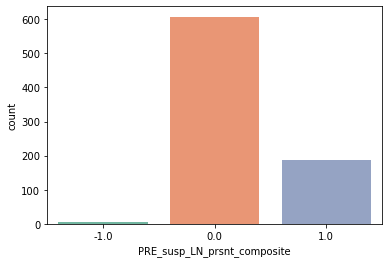

In [64]:

section, dtype, label, options, options_str = read_col_attributes("PRE_susp_LN_prsnt_composite")
# Check results
print("Value counts for pre_susp_LN_prsnt_composite:")
print(susp_LN_present_composite.value_counts())
# Make the x-tick label correspond to option label
x_tick_labels = [f"{k} ({v})" for k, v in options.items()]
# Plot the distribution of the pre_susp_LN_prsnt_composite
sns.countplot(x="PRE_susp_LN_prsnt_composite", data=df, palette="Set2")
pd.concat([df[susp_LN_present_composite_cols], susp_LN_present_composite], axis=1).head()

Value counts for pre_susp_LN_max_size_composite:
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun18/PRE_susp_LN_max_size_composite.png


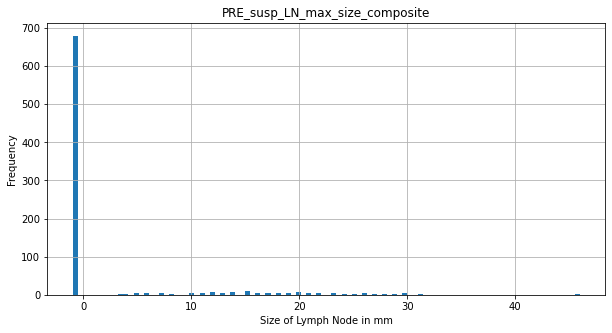

In [65]:
# Check results - Plot the column with sorted values 
print("Value counts for pre_susp_LN_max_size_composite:")
susp_LN_max_size_composite.hist(bins=100)
# Mark the axis and median value 
# plt.axvline(susp_LN_max_size_composite.median(), color="r", linestyle="--")
plt.title("PRE_susp_LN_max_size_composite")
plt.xlabel(f"Size of Lymph Node in mm")
plt.ylabel("Frequency")
save_plot("PRE_susp_LN_max_size_composite")
# plt.show()

Value counts for pre_tumor_max_size_composite:
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun18/PRE_tumor_max_size_composite.png


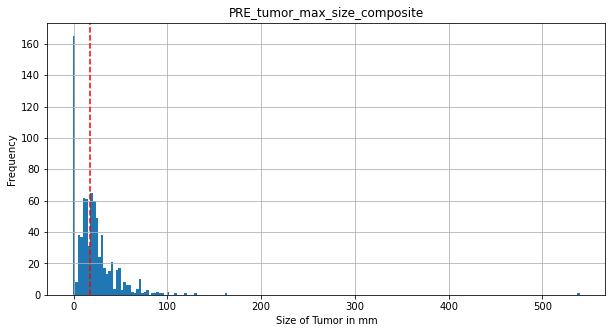

In [66]:
# Check results - Plot the column with sorted values 
print("Value counts for pre_tumor_max_size_composite:")
# Make a histogram of the column, with bins of 50
pre_tumor_max_size_composite.hist(bins=200)
# Mark the axis and median value
plt.axvline(pre_tumor_max_size_composite.median(), color="r", linestyle="--")
plt.title("PRE_tumor_max_size_composite")
plt.xlabel("Size of Tumor in mm")
plt.ylabel("Frequency")
save_plot("PRE_tumor_max_size_composite")

In [67]:
# Save the dataframe to a csv file
out_csv_path = os.path.join(data_dir, "data_with_composite.csv")
# Replace all instances of -1 with NaN
df_save = df.replace(-1, np.nan)
df_save.to_csv(out_csv_path, index=False)
print("Saved dataframe to: {}".format(out_csv_path))

Saved dataframe to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/data_with_composite.csv


--------------------------------------------------
PRE_susp_LN_prsnt_composite (yesno, PRE) vs POS_lymphovascular_invasion (radio, POS)
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun18/PRE_susp_LN_prsnt_composite_vs_POS_lymphovascular_invasion_cross_tabinc_missing


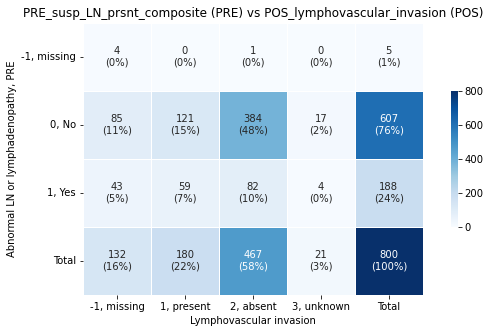

PRE_susp_LN_prsnt_composite (yesno, PRE) vs POS_metastasis (radio, POS)
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun18/PRE_susp_LN_prsnt_composite_vs_POS_metastasis_cross_tabinc_missing


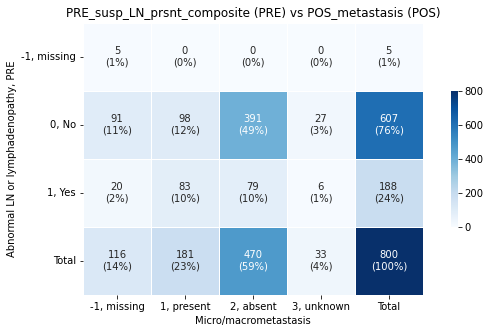

PRE_susp_LN_prsnt_composite (yesno, PRE) vs POS_ln_w_micrometastasis (text, POS)


In [85]:
# Explore and visualize the relationship between the PRE composite features and the post nodal columns
# For each post nodal column, plot the distribution of the PRE composite features
from sklearn.linear_model import HuberRegressor


def cross_tab_plots(cross_tab_cols_set1, cross_tab_cols_set2, show_plots, plot_missing=False):
    for col1 in cross_tab_cols_set1:
        print("-"*50)
        section1, dtype1, label1, options1, options_str1 = read_col_attributes(col1)
        for col2 in cross_tab_cols_set2:
            section2, dtype2, label2, options2, options_str2 = read_col_attributes(col2)
            print(f"{col1} ({dtype1}, {section1}) vs {col2} ({dtype2}, {section2})")
            plt.title(f"{col1} ({section1}) vs {col2} ({section2})", fontsize=12, loc="center")
            # plt.title(f"({label1} vs {label2})")
            # Make a second row beneath title for the labels
            # Depending on the dtype of the columns, use different plotting functions
            if is_dtype_categorical(dtype1) and is_dtype_categorical(dtype2):
                # continue
                # If both are categorical, create a contingency table with percentages and margins
                df_cross_tab = pd.crosstab(df[col1], df[col2], margins=True)
                # Rename "All" with "Total" in the df_cross_tab columns and indices
                df_cross_tab.columns = df_cross_tab.columns.tolist()[:-1] + ["Total"]
                df_cross_tab.index = df_cross_tab.index.tolist()[:-1] + ["Total"]
                # Create percentages from cross-tab table
                values = df_cross_tab.values
                # Calculate percentages excluding the last row and last column
                percentages = values[:-1, :-1] / (values[:-1, :-1].sum()) * 100
                # Create column/row-wise margins of percentages 2D array
                row_margins = np.sum(percentages, axis=1)
                # Append 100 to row_margins
                row_margins = np.append(row_margins, 100)
                col_margins = np.sum(percentages, axis=0) 
                # Append col_margins to the end of percentages
                percentages = np.append(percentages, col_margins.reshape(1, percentages.shape[1]), axis=0)
                # Append the row_margins to the end of percentages
                percentages = np.append(percentages, row_margins.reshape(percentages.shape[0], 1), axis=1)
                annotations = np.array([f"{x}\n({round(y)}%)" for x, y in zip(values.flatten(), percentages.flatten())]).reshape(df_cross_tab.shape)
                # Rename the x-ticks and y-ticks with the options
                y_tick_labels = list([f"{k}, {v}" for k, v in options1.items()]) + ["Total"]
                x_tick_labels = list([f"{k}, {v}" for k, v in options2.items()]) + ["Total"]
                # Rotate the x-ticks and y-ticks
                # Plot the cross-tab table, which is a heatmap with no colors and black grid
                sns.heatmap(
                    df_cross_tab, annot=annotations, fmt="", cmap="Blues", annot_kws={"size": 10}, linewidths=1,
                    cbar=True, square=True, cbar_kws={"shrink": 0.5}, xticklabels=x_tick_labels, yticklabels=y_tick_labels)
                # # Add the options as x-axis labels and y-axis labels
                plt.xlabel(f"{label2}") # \n {options_str2}")
                plt.ylabel(f"{label1}") # \n {options_str1}")
                plt.xticks(rotation=0)
                plt.yticks(rotation=0)
                # Align the ticks to the center of the cell
                # Save plot
                plot_name = f"{col1}-vs-{col2}_cross_tab"
            elif is_dtype_categorical(dtype1) or is_dtype_categorical(dtype2):  # One is categorical, the other is numerical
                # continue
                # If one is categorical, create a histogram with overlapping groups/categories
                cat_col, num_col = (col1, col2) if is_dtype_categorical(dtype1) else (col2, col1)
                cat_section, cat_dtype, cat_label, cat_options, cat_options_str = read_col_attributes(cat_col)
                num_section, num_dtype, num_label, num_options, num_options_str = read_col_attributes(num_col)
                # Create a histogram with overlapping groups/categories using matplotlib
                # The y-axis is the number of patients with the category
                # The x-axis is the numeric column
                # The color of the histogram is the category
                data = {}
                num_missingness = {}
                # Precompute the bins for the numeric column
                bins = np.linspace(df[num_col].min(), df[num_col].max(), 500)
                for cat in cat_options.keys():
                    num_data = df[df[cat_col] == cat][num_col].values
                    # Count the number of -1 values in the data
                    num_missing_count = np.count_nonzero(num_data == -1)
                    data[cat] = [x for x in num_data if x != -1 and not np.isnan(x)]
                    # Remove all instances of -1 and nan from the data
                    # If cat is "missing", instead of creating a histogram, make a caption with the number of missing values
                    if cat == -1 and not plot_missing:
                        cat_missingness = len(num_data)
                    else:
                        num_missingness[cat] = num_missing_count
                        # Plot the histogram with half-tranparent bars, using log-scale with 10 bins
                        plt.hist(data[cat], bins=bins, alpha=0.5, log=False)
                        #  bins=np.arange(min(data[cat]), max(data[cat]) + 1, 1), alpha=0.5, log=True)
                        # Plot the group median as a line with the same color as the histogram
                        # plt.axvline(np.median(data[cat]), linestyle="dashed")
                        # Draw the legend using categorical labels and options
                # Make grid background with gridlines
                plt.grid(which="major", axis="x", linestyle="-", linewidth=0.3, color="grey")
                plt.grid(which="major", axis="y", linestyle="-", linewidth=0.3, color="grey")
                plt.legend([f"{k}, {v} (N={len(data[k])})" for k, v in cat_options.items() if k != -1])
                plt.xlabel(f"{num_label}")  # \n(N={len(df) - cat_missingness})")
                plt.ylabel(f"Patient count of \n'{cat_label}'")
                plot_name = f"{cat_col}-vs-{num_col}_hist"
                
            else:  # Both are numerical
                # If both are numerical, create a scatter plot with the two columns
                # The x-axis is the first column, the y-axis is the second column
                data = zip(df[col1], df[col2])
                # Remove all instances of -1 and nan from the data
                data = [x for x in data if x[0] != -1 and not np.isnan(x[0]) and x[1] != -1 and not np.isnan(x[1])]
                x_data = [x[0] for x in data]
                y_data = [x[1] for x in data]
                # Plot the scatter plot
                plt.scatter(x_data, y_data, alpha=0.2)
                # Fit a linear regression line to the data and plot it
                slope, intercept = np.polyfit(x_data, y_data, 1)
                plt.plot(x_data, [slope * x + intercept for x in x_data], color="orange", linewidth=1, alpha=0.5)
                # Write the regression equation as opaque text on the top-left corner of the plot
                slope, intercept = round(slope, 2), round(intercept, 2)
                text = f"Linear Regression: y = {slope} * x + {intercept}"
                plt.text(0.05, 0.98, text, transform=plt.gca().transAxes, fontsize=10, va="top", alpha=0.7, color="orange")
                # Add another regression line that is robust to outliers using HuberRegressor
                sklearn_x_data = np.array(x_data).reshape(-1, 1)
                sklearn_y_data = np.array(y_data)
                huber_epsilon = 1.5
                model = HuberRegressor(epsilon=huber_epsilon)
                model.fit(sklearn_x_data, sklearn_y_data)
                # Plot the fitted line
                plt.plot(x_data, model.predict(sklearn_x_data), color="red", linewidth=1, alpha = 0.5)
                # Write the regression equation as opaque text on the top-left corner of the plot
                text = f"Huber Regression (robust to outliers, ε = {huber_epsilon}): y = {round(model.coef_[0], 2)} * x + {round(model.intercept_, 2)}"
                plt.text(0.05, 0.93, text, transform=plt.gca().transAxes, fontsize=10, va="top", alpha=0.7, color="red")
                # Make grid background with gridlines
                plt.grid(which="major", axis="x", linestyle="-", linewidth=0.3, color="grey")
                plt.grid(which="major", axis="y", linestyle="-", linewidth=0.3, color="grey")
                # Add a caption for number of data points to the top-right of the plot
                plt.text(0.98, 0.98, f"N={len(data)}", horizontalalignment="right", verticalalignment="top", transform=plt.gca().transAxes)
                # Add labels to the axes
                plt.xlabel(f"{label1}")
                plt.ylabel(f"{label2}")
                plot_name = f"{col1}-vs-{col2}_scatter"
            save_plot(plot_name, plot_missing)
            if show_plots:
                plt.show()
cross_tab_plots(cross_tab_cols_set1, cross_tab_cols_set2, show_plots=True, plot_missing=True)

In [69]:
# # calculate and print the pair-wise correlations between cross_tab_cols_set1 and cross_tab_cols_set2
# # the correlation should exclude nan and -1 values
# corr_set1_set2 = OrderedDict()
# for col1 in cross_tab_cols_set1:
#     for col2 in cross_tab_cols_set2:
#         print("-" * 20 + f"Processing {col1} and {col2}" + "-" * 20)
#         section1, dtype1, label1, options1, options_str1 = read_col_attributes(col1)
#         section2, dtype2, label2, options2, options_str2 = read_col_attributes(col2)
#         # Remove rows where either col1 or col2 is -1 or nan
#         data = zip(df[col1], df[col2])
#         data = [x for x in data if x[0] != -1 and not np.isnan(x[0]) and x[1] != -1 and not np.isnan(x[1])]
#         x_data = [x[0] for x in data]
#         y_data = [x[1] for x in data]
#         # Apply map to the data, depending on the options
#         for val1, desc1 in options1.items():
#             if val1 == 2 and desc1.lower() == "indeterminate":
                
                
#             elif val1 == 3 and desc1.lower() == "unknown":
#                 # Replace all occurences of 3 with 0.5 in the data
#                 x_data = [x if x != 3 else 0.5 for x in x_data]
#                 print(f"Replaced all 3 values with 0.5 in {col1} because it is unknown")
#             elif val1 == 2 and desc1.lower() == "absent":
#                 # Replace all occurences of 2 with 0 in the data
#                 x_data = [x if x != 2 else 0 for x in x_data]
#                 print(f"Replaced all 2 values with 0 in {col1} because it is absent")

#         # Calculate the correlation between the two columns
#         corr = np.corrcoef(x_data, y_data)[0, 1]
#         corr_set1_set2[(col1, col2)] = (corr, len(data))
        


# # Print the correlations
# # First sort the correlation by absolute value
# corr_set1_set2 = OrderedDict(sorted(corr_set1_set2.items(), key=lambda x: abs(x[1][0]), reverse=True))
# for (col1, col2), (corr, len_data) in corr_set1_set2.items():
#     section1, dtype1, label1, options1, options_str1 = read_col_attributes(col1)
#     section2, dtype2, label2, options2, options_str2 = read_col_attributes(col2)
#     print("-"*50)
#     print(f"options for {col1}: {options_str1}")
#     print(f"options for {col2}: {options_str2}")
#     print(f"Correlation between: {label1} ({section1}) & {label2} ({section2}) = {round(corr, 2)}   (N={len_data})")
    